In [393]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

Found a csv version of the penguins dataset online, read it in with Pandas

In [372]:
url = 'https://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv'
penguin_df = pd.read_csv(url, index_col=0) # set the rowid to be the index

There are 3 species, I will arbitrarily choose Gentoo and Chinstrap

In [373]:
print(f"Before: {penguin_df['species'].unique()}")
penguin_df = penguin_df[(penguin_df['species'] == 'Gentoo') | (penguin_df['species'] == 'Chinstrap')]
print(f"After: {penguin_df['species'].unique()}")

Before: ['Adelie' 'Gentoo' 'Chinstrap']
After: ['Gentoo' 'Chinstrap']


Easiest way to handle missing data is to drop it from the dataset.

In [374]:
print(penguin_df.isna().sum())
penguin_df = penguin_df.dropna()

species              0
island               0
bill_length_mm       1
bill_depth_mm        1
flipper_length_mm    1
body_mass_g          1
sex                  5
year                 0
dtype: int64


Need to transform from categorical to numerical labels. Append a species_label column.\
\
We need to decide what the features and target variables are. In this case, we want to use physical features (features) to estimate what the species of the penguin is (target)

In [375]:
label_encode = LabelEncoder()
penguin_df['species_label'] = label_encode.fit_transform(penguin_df['species'])
# island, sex, and year are not relevant to the species if we assume 50% are male and 50% are female across the species.
features = penguin_df.loc[:, 'bill_length_mm' : 'body_mass_g']
X = features
y = penguin_df['species_label']

As a general guideline, it is important to scale the data between 0 and 1

In [376]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

Fit and predict the Naive Bayes and Logistic Regression models

In [377]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_train_nb = nb_model.predict(X_train)
y_pred_test_nb = nb_model.predict(X_test)

lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

#### 1.
Accuracy score is about as simple as it gets.. confusion matrix is also a great visualizer of the performance of each class. Given that the Naive Bayes and Logistic Regression models are both 100% accuracy, this is not necessary.

In [378]:
nb_train_acc = accuracy_score(y_train, y_pred_train_nb)
nb_test_acc = accuracy_score(y_test, y_pred_test_nb)
lr_train_acc = accuracy_score(y_train, y_pred_train_lr)
lr_test_acc = accuracy_score(y_test, y_pred_test_lr)

In [379]:
print(f"Naive Bayes training accuracy: {nb_train_acc:.2f}\nNaive Bayes test accuracy: {nb_test_acc:.2f}")
print(f"Logistic regression training accuracy: {lr_train_acc:.2f}\nLogistic regression test accuracy: {lr_test_acc:.2f}")

Naive Bayes training accuracy: 1.00
Naive Bayes test accuracy: 1.00
Logistic regression training accuracy: 1.00
Logistic regression test accuracy: 1.00


#### 2.
At first I was confused why the roc_auc_score takes in only one class but it makes sense when it is binary and they add up to 1

In [380]:
nb_train_prob = nb_model.predict_proba(X_train)
nb_test_prob = nb_model.predict_proba(X_test)
train_auc_nb = roc_auc_score(y_train, nb_train_prob[:, 1])
test_auc_nb = roc_auc_score(y_test, nb_test_prob[:, 1])

lr_train_prob = lr_model.predict_proba(X_train)
lr_test_prob = lr_model.predict_proba(X_test)
train_auc_lr = roc_auc_score(y_train, lr_train_prob[:, 1])
test_auc_lr = roc_auc_score(y_test, lr_test_prob[:, 1])

Identical scores of 1.0 for Gentoo and Chinstrap. Adelie and Chinstrap scored slightly differently. 0.98 and 0.97 for Naive Bayes train and test, and 0.99 for both logistic regression train and test scores. See below for a slightly more detailed explanation using the AUC plots.

In [381]:
print(f"Naive Bayes train score: {train_auc_nb:.2f}\nNaive Bayes test score: {test_auc_nb:.2f}")
print(f"Logistic Regression train score: {train_auc_lr:.2f}\nLogistic Regression test score: {test_auc_lr:.2f}")

Naive Bayes train score: 1.00
Naive Bayes test score: 1.00
Logistic Regression train score: 1.00
Logistic Regression test score: 1.00


fpr = false positive rate, tpr = true positive rate

In [382]:
nb_train_fpr, nb_train_tpr, _ = roc_curve(y_train, nb_train_prob[:, 1])
nb_test_fpr, nb_test_tpr, _ = roc_curve(y_test, nb_test_prob[:, 1])
lr_train_fpr, lr_train_tpr, _ = roc_curve(y_train, lr_train_prob[:, 1])
lr_test_fpr, lr_test_tpr, _ = roc_curve(y_test, lr_test_prob[:, 1])

The best performing model would maximize the area under the ROC curve. In this specific example, they both have an area of 1, the maximum possible. However, I re-ran the model on Adelie and Chinstrap penguins and found that the Logistic Regression model performed better. I would assume this is because the Naive Bayes assumption that each feature is independent, which isn't necessarily true. For example, body mass and flipper length may be correlated. Still, the performance of both models is good.
This visualization isn't necessary but I thought it is interesting to see.

Text(0.5, 0.01, 'False Positive Rate (FPR)')

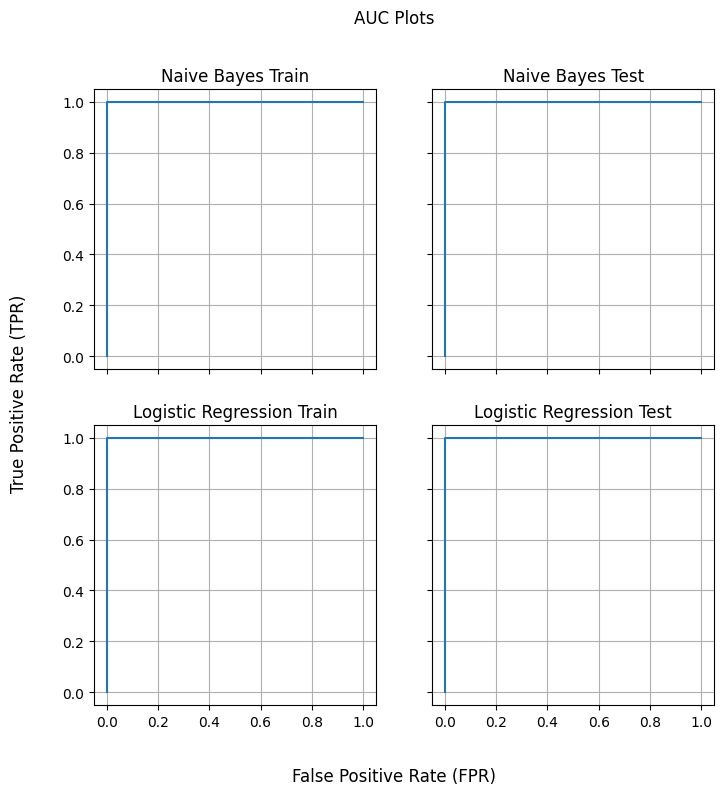

In [383]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
ax[0][0].plot(nb_train_fpr, nb_train_tpr)
ax[0][0].set_title('Naive Bayes Train')
ax[0][0].grid(True)
ax[0][1].plot(nb_test_fpr, nb_test_tpr)
ax[0][1].set_title('Naive Bayes Test')
ax[0][1].grid(True)
ax[1][0].plot(lr_train_fpr, lr_train_tpr)
ax[1][0].set_title('Logistic Regression Train')
ax[1][0].grid(True)
ax[1][1].plot(lr_test_fpr, lr_test_tpr)
ax[1][1].set_title('Logistic Regression Test')
ax[1][1].grid(True)
fig.suptitle('AUC Plots')
fig.supylabel('True Positive Rate (TPR)')
fig.supxlabel('False Positive Rate (FPR)')

#### 3.
qcut is a great function to discretize a specific variable into equal-sized buckets based on q quantiles, 10 would give us deciles

In [384]:
def lift_gain(prob, y_true):
    df = pd.DataFrame({'prob': prob, 'actual': y_true})
    df = df.sort_values('prob', ascending=False)
    df['decile'] = pd.qcut(df['prob'], 10, labels=False) + 1

    total_positives = df['actual'].sum()

    lift_gain_df = df.groupby('decile')['actual'].agg(['sum', 'count']).reset_index()
    lift_gain_df['cumulative_positives'] = lift_gain_df['sum'].cumsum()
    lift_gain_df['gain'] = round(lift_gain_df['cumulative_positives'] / total_positives * 100, 2)
    lift_gain_df['lift'] = round(lift_gain_df['sum'] / (lift_gain_df['count'] * total_positives / len(df)), 2)

    return lift_gain_df


In [385]:
nb_lg_train = lift_gain(nb_train_prob[:, 1], y_train)
nb_lg_test = lift_gain(nb_test_prob[:, 1], y_test)
lr_lg_train = lift_gain(lr_train_prob[:, 1], y_train)
lr_lg_test = lift_gain(lr_test_prob[:, 1], y_test)

Because of the identical performance between the models, the gain and lift charts are also identical. We can still extract useful information from this, though. Each model is performing much better than random selection as indicated by the lift.

Text(0.5, 0.98, 'Lift and Gain Charts for Naive Bayes and Logistic Regression')

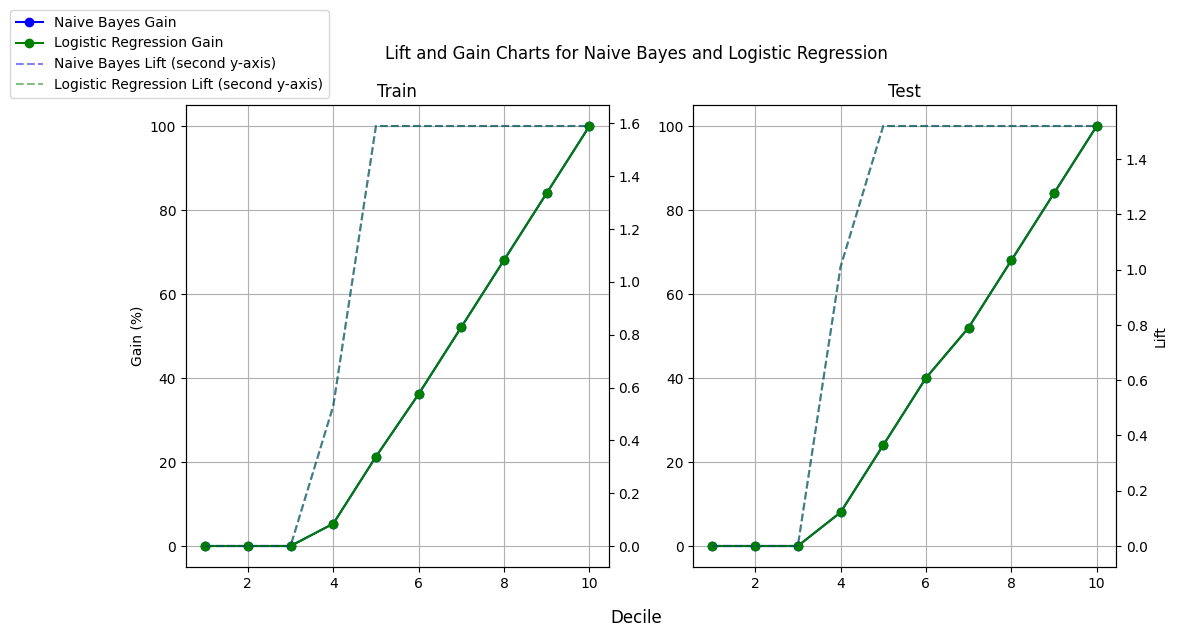

In [436]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

# Train
ax[0]
ax[0].plot(nb_lg_train['decile'], nb_lg_train['gain'], label='Naive Bayes Gain', color='blue', marker='o')  # nb gain
ax[0].plot(lr_lg_train['decile'], lr_lg_train['gain'], label='Logistic Regression Gain', color='green', marker='o')  # lr gain
ax[0].set_title('Train')
ax[0].grid(True)
ax[0].set_ylabel('Gain (%)')

ax0_twin = ax[0].twinx()
ax0_twin.plot(nb_lg_train['decile'], nb_lg_train['lift'], label='Naive Bayes Lift (second y-axis)', color='blue', linestyle='--', alpha=0.5)  # nb lift on second y-axis
ax0_twin.plot(lr_lg_train['decile'], lr_lg_train['lift'], label='Logistic Regression Lift (second y-axis)', color='green', linestyle='--', alpha=0.5)  # lr lift on second y-axis

# Test
ax[1]
ax[1].plot(nb_lg_test['decile'], nb_lg_test['gain'], label='Naive Bayes Gain', color='blue', marker='o')  # nb gain
ax[1].plot(lr_lg_test['decile'], lr_lg_test['gain'], label='Logistic Regression Gain', color='green', marker='o')  # lr gain
ax[1].set_title('Test')
ax[1].grid(True)

ax1_twin = ax[1].twinx()
ax1_twin.plot(nb_lg_test['decile'], nb_lg_test['lift'], label='Naive Bayes Lift (second y-axis)', color='blue', linestyle='--', alpha=0.5)  # nb lift on second y-axis
ax1_twin.plot(lr_lg_test['decile'], lr_lg_test['lift'], label='Logistic Regression Lift (second y-axis)', color='green', linestyle='--', alpha=0.5)  # lr lift on second y-axis
ax1_twin.set_ylabel('Lift')

handles, labels = [], []
for ax_ in [ax[0], ax0_twin]:
    for handle, label in zip(*ax_.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, ncol=1, bbox_to_anchor=(0.25, 1.05))

fig.supxlabel('Decile')
fig.suptitle('Lift and Gain Charts for Naive Bayes and Logistic Regression')

#### 4.
In this case, the models performed identically. But I tested Adelie and Chinstrap as well to compare them and found the logistic regression performs better. I assume this is because some of the features are not actually independent of each other, which is a common place where the Naive Bayes model can screw up.

#### 5.

In [387]:
mnist_X, mnist_y = fetch_openml('mnist_784', return_X_y=True)

In [388]:
print(mnist_X.max().max()) # need to rescale
mnist_X = mnist_X / 255.
print(mnist_X.max().max())

255
1.0


In [389]:
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(mnist_X, mnist_y, train_size=0.8, random_state=0)

In [390]:
nb_model_mnist = GaussianNB()
nb_model_mnist.fit(mnist_X_train, mnist_y_train)
mnist_nb_pred_train = nb_model_mnist.predict(mnist_X_train)
mnist_nb_pred_test = nb_model_mnist.predict(mnist_X_test)

lr_model_mnist = LogisticRegression(random_state=0)
lr_model_mnist.fit(mnist_X_train, mnist_y_train)
mnist_lr_pred_train = lr_model_mnist.predict(mnist_X_train)
mnist_lr_pred_test = lr_model_mnist.predict(mnist_X_test)

c:\Users\rfibe\miniconda3\envs\assignment_2\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [391]:
mnist_nb_train_acc = accuracy_score(mnist_y_train, mnist_nb_pred_train)
mnist_nb_test_acc = accuracy_score(mnist_y_test, mnist_nb_pred_test)
mnist_lr_train_acc = accuracy_score(mnist_y_train, mnist_lr_pred_train)
mnist_lr_test_acc = accuracy_score(mnist_y_test, mnist_lr_pred_test)

In [392]:
print(f"Naive Bayes training accuracy: {mnist_nb_train_acc:.2f}\nNaive Bayes test accuracy: {mnist_nb_test_acc:.2f}")
print(f"Logistic regression training accuracy: {mnist_lr_train_acc:.2f}\nLogistic regression test accuracy: {mnist_lr_test_acc:.2f}")

Naive Bayes training accuracy: 0.55
Naive Bayes test accuracy: 0.55
Logistic regression training accuracy: 0.94
Logistic regression test accuracy: 0.92


Naive Bayes underperforms beacuse it assumes each pixel probability is independent of each other - which they are not, neigboring pixels are highly correlated. This likely causes the model to miss spatial relationships within each image.\
The difference in performance between MNIST and the penguins dataset makes sense. MNIST is high dimensional and very highly correlated, both of which lower the performance of the Naive Bayes model. Logistic regression is more of a generalist model which explains why it is able to adapt to both of the datasets.